# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from termcolor import colored
import pandas as pd
import numpy as np
import uproot
import lightgbm as lgb #load MVA
from tqdm.auto import tqdm
tqdm.pandas()
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

training_variables = util.training_variables
columns = util.all_relevant_variables + ['__MCDecayString__']

Welcome to JupyROOT 6.26/14


In [3]:
# MC_cc = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb_control/*_withDecayString.root:B0'],
#                           library="np",
#                           #cut = '(D_M>1.855) & (D_M<1.885)',
#                           filter_branch=lambda branch: branch.name in columns)
# df_mc_cc = pd.DataFrame(MC_cc)
# df_mc_cc.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
# df_mc_cc.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)
# BDT_sig='signal_prob==largest_prob and signal_prob>0.8 and fakeB_prob<0.04 and fakeD_prob<0.05'
# df_mc_cc_BDT_sig = util.apply_mva_bcs(df_mc_cc, training_variables, BDT_sig)
# samples_sig = util.get_dataframe_samples_new(df_mc_cc_BDT_sig, 'e', template=False)

In [10]:
# cc = samples_sig['bkg_combinatorial'].query('ell_genMotherPDG * D_genMotherPDG==411*511')
# print(cc['__MCDecayString__'].iloc[4])

Content of MCParticle list
╰── Upsilon(4S) (300553)
    ├── B0 (511)
    │   ├── D- (-411)
    │   │   ├── K0 (311)
    │   │   │   ╰── K_L0 (130)
    │   │   │       ├╶╶ pi- (-211)
    │   │   │       ├╶╶ pi+ (211)
    │   │   │       │   ├╶╶ nu_mu (14)
    │   │   │       │   ├╶╶ mu+ (-13)
    │   │   │       │   │   ├╶╶ anti-nu_mu (-14)
    │   │   │       │   │   ├╶╶ nu_e (12)
    │   │   │       │   │   ╰╶╶ e+ (-11)
    │   │   │       │   ╰╶╶ e- (11)
    │   │   │       ╰╶╶ n0 (2112)
    │   │   ├── e- (11)
    │   │   │   ╰╶╶ gamma (22)
    │   │   ├── anti-nu_e (-12)
    │   │   ╰── gamma (22)
    │   ├── pi+ (211)
    │   │   ├╶╶ nu_mu (14)
    │   │   ╰╶╶ mu+ (-13)
    │   │       ├╶╶ anti-nu_mu (-14)
    │   │       ├╶╶ nu_e (12)
    │   │       ╰╶╶ e+ (-11)
    │   ├── rho+ (213)
    │   │   ├── pi+ (211)
    │   │   │   ╰╶╶ pi- (-211)
    │   │   ╰── pi0 (111)
    │   │       ├── gamma (22)
    │   │       ╰── gamma (22)
    │   │           ╰╶╶ gamma (22)
    │   ├── eta (

In [2]:
# 4S wrong charge Data vs MC, and MC wc vs cc

# Load data files
MC_cc = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb_control/*.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

MC_wc = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_wrongCharge_200fb_noCut/*.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

data_wc = uproot.concatenate([f'../../Samples/Data/e_channel/WC/proc13_4S_wc_e_persian_3.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

df_mc_cc = pd.DataFrame(MC_cc)
df_mc_wc = pd.DataFrame(MC_wc)
df_data_wc = pd.DataFrame(data_wc)

BDT_combinatorial='signal_prob>0.3 and fakeB_prob<0.8 and fakeD_prob<0.05'
BDT_sig='signal_prob==largest_prob and signal_prob>0.8 and fakeB_prob<0.04 and fakeD_prob<0.05'
BDT_no_sig = 'signal_prob<0.3'

In [3]:
for df in [df_mc_cc, df_mc_wc, df_data_wc,]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [4]:
# BCS
df_mc_cc_BDT_sig = util.apply_mva_bcs(df_mc_cc, training_variables, BDT_sig)
df_mc_wc_BDT_sig = util.apply_mva_bcs(df_mc_wc, training_variables, BDT_sig)
df_data_wc_BDT_sig = util.apply_mva_bcs(df_data_wc, training_variables, BDT_sig)

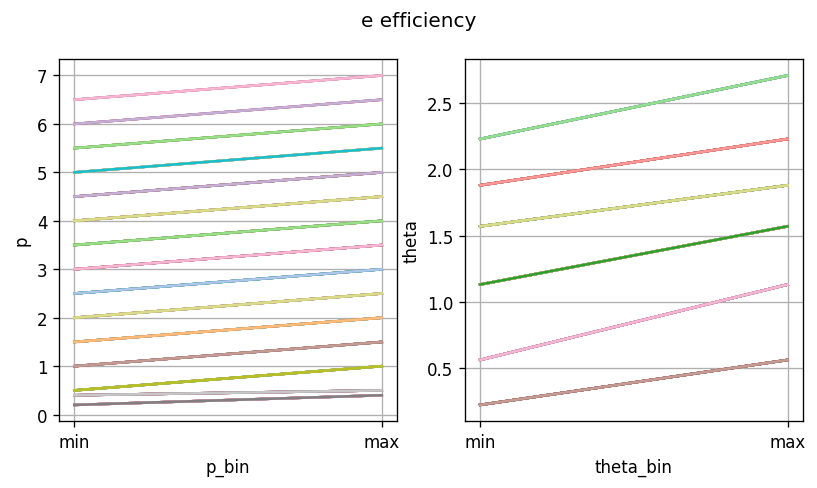

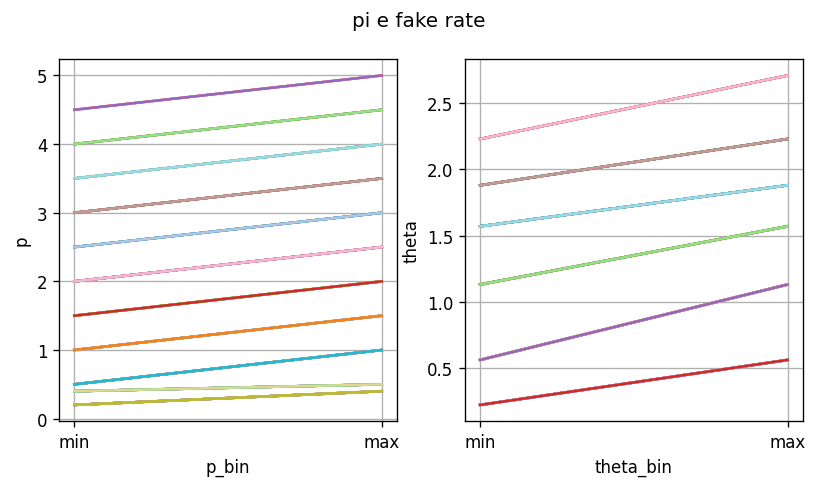

In [5]:
# PID corrections, get tables
pid = util.PID_corrections()
exclude_e_bins_query = "not (p_min == 0.2 and p_max == 5.0) \
and not (theta_min == 0.22 and theta_max == 2.71) \
and not (theta_min == 0.56 and theta_max == 2.23)"
e_eff, e_fake = pid.get_lepton_tables(lepton='e', var="pidChargedBDTScore_e",
                          thres=0.9, exclude_bins=exclude_e_bins_query)
K_eff, K_fake = pid.get_hadron_tables(new_table=False, hadron='K', var='kaonIDNN', thres=0.9)

Required variables: ['ell_theta', 'ell_p', 'ell_charge', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 95.9%
Required variables: ['D_K_p', 'D_K_cosTheta', 'D_K_charge', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 95.6%
Required variables: ['ell_theta', 'ell_p', 'ell_charge', 'ell_PDG', 'ell_mcPDG']


/tmp/ipykernel_1942482/2577435579.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


Coverage:
PID ell: 86.6%
Required variables: ['D_K_p', 'D_K_cosTheta', 'D_K_charge', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 85.6%


/tmp/ipykernel_1942482/2577435579.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


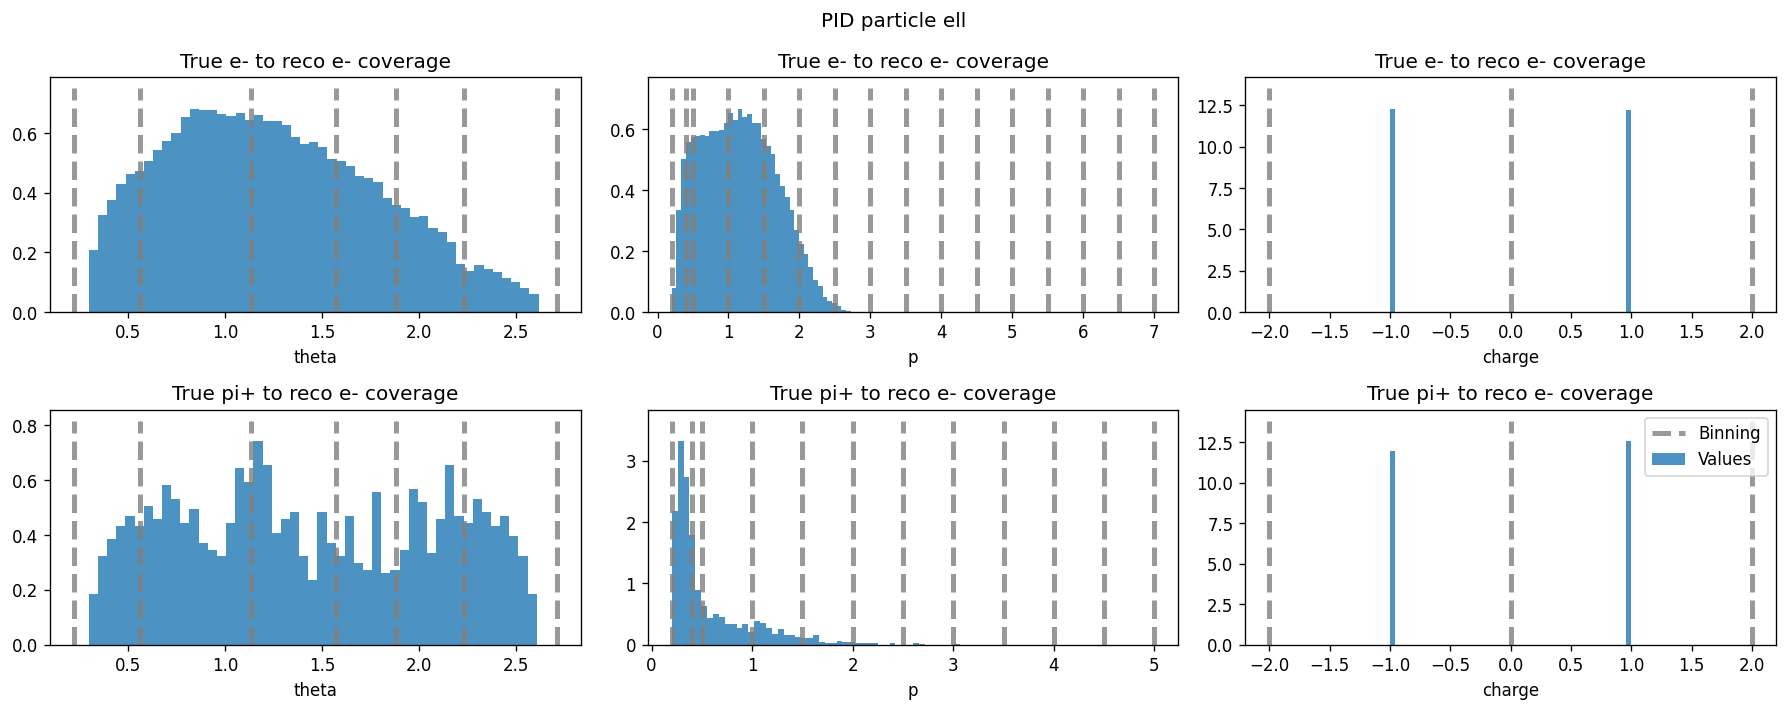

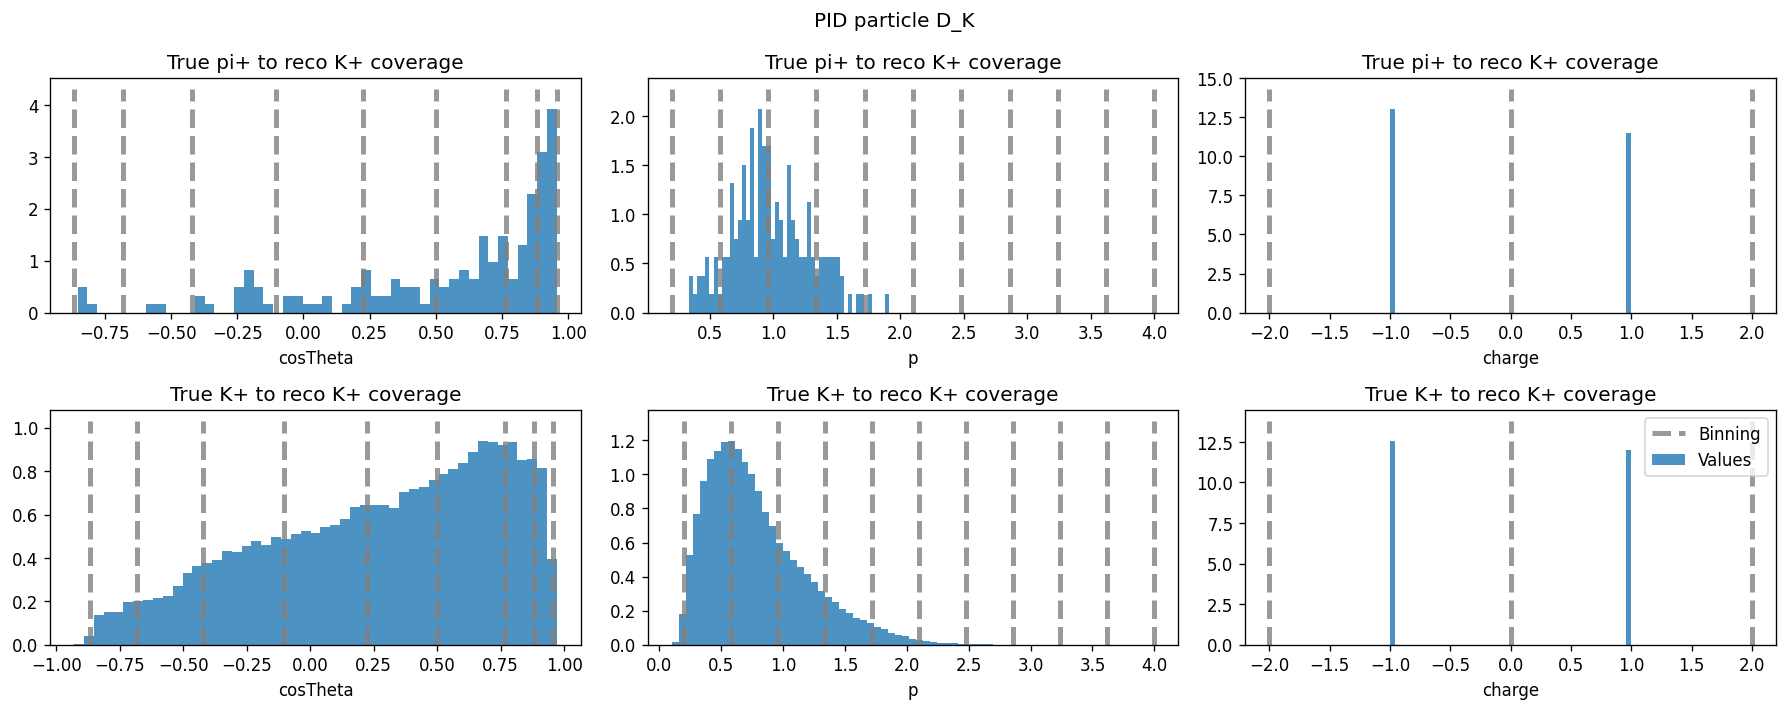

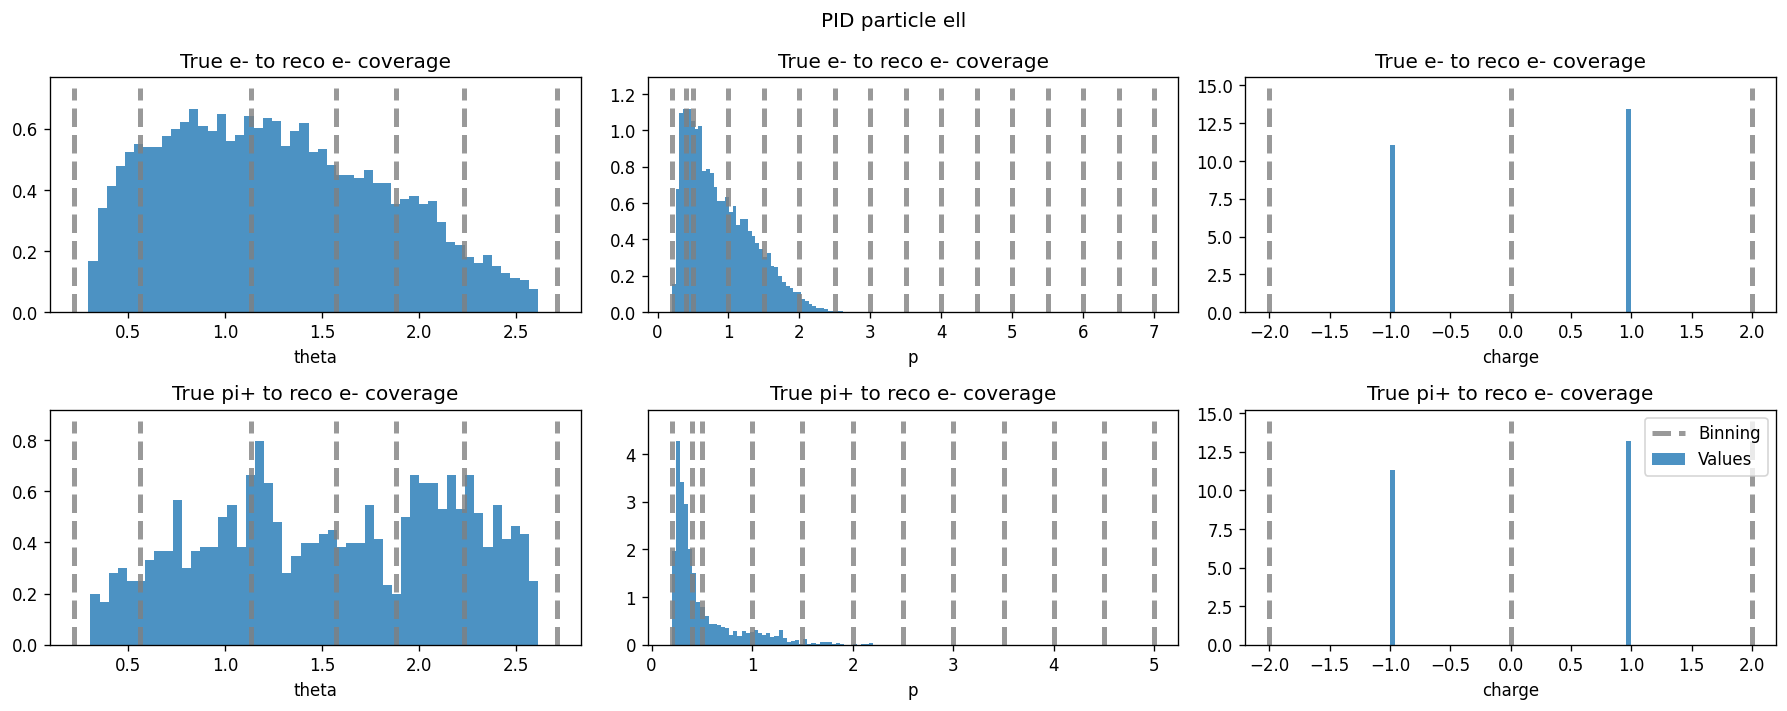

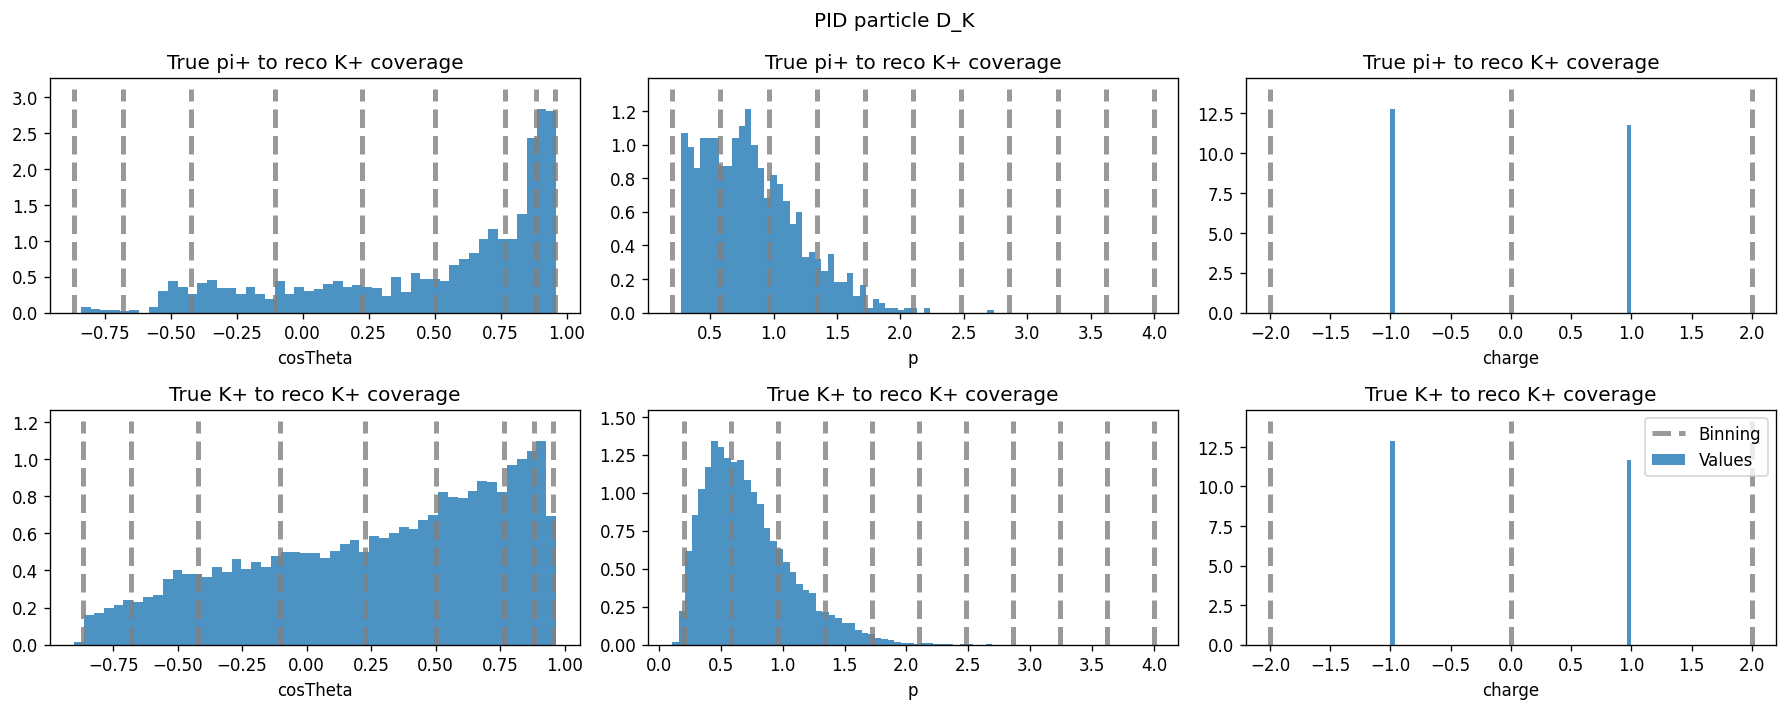

In [6]:
# Apply PID corrections
for df in [df_mc_cc_BDT_sig, df_mc_wc_BDT_sig]:
    pid.apply_corrections(eff_table=e_eff, fake_table=e_fake, df=df, plots=True,
                          p='e', var='pidChargedBDTScore_e', thres=0.9)
    pid.apply_corrections(eff_table=K_eff, fake_table=K_fake, df=df, plots=True,
                          p='K', var='kaonIDNN', thres=0.9)
    df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)
    df = df.copy()

In [4]:
# df_mc_BDT_combi = util.apply_mva_bcs(df_mc, training_variables, BDT_combinatorial)
# df_data_BDT_combi = util.apply_mva_bcs(df_data, training_variables, BDT_combinatorial)

# df_mc_BDT_no_sig = util.apply_mva_bcs(df_mc, training_variables, BDT_no_sig)
# df_data_BDT_no_sig = util.apply_mva_bcs(df_data, training_variables, BDT_no_sig)

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


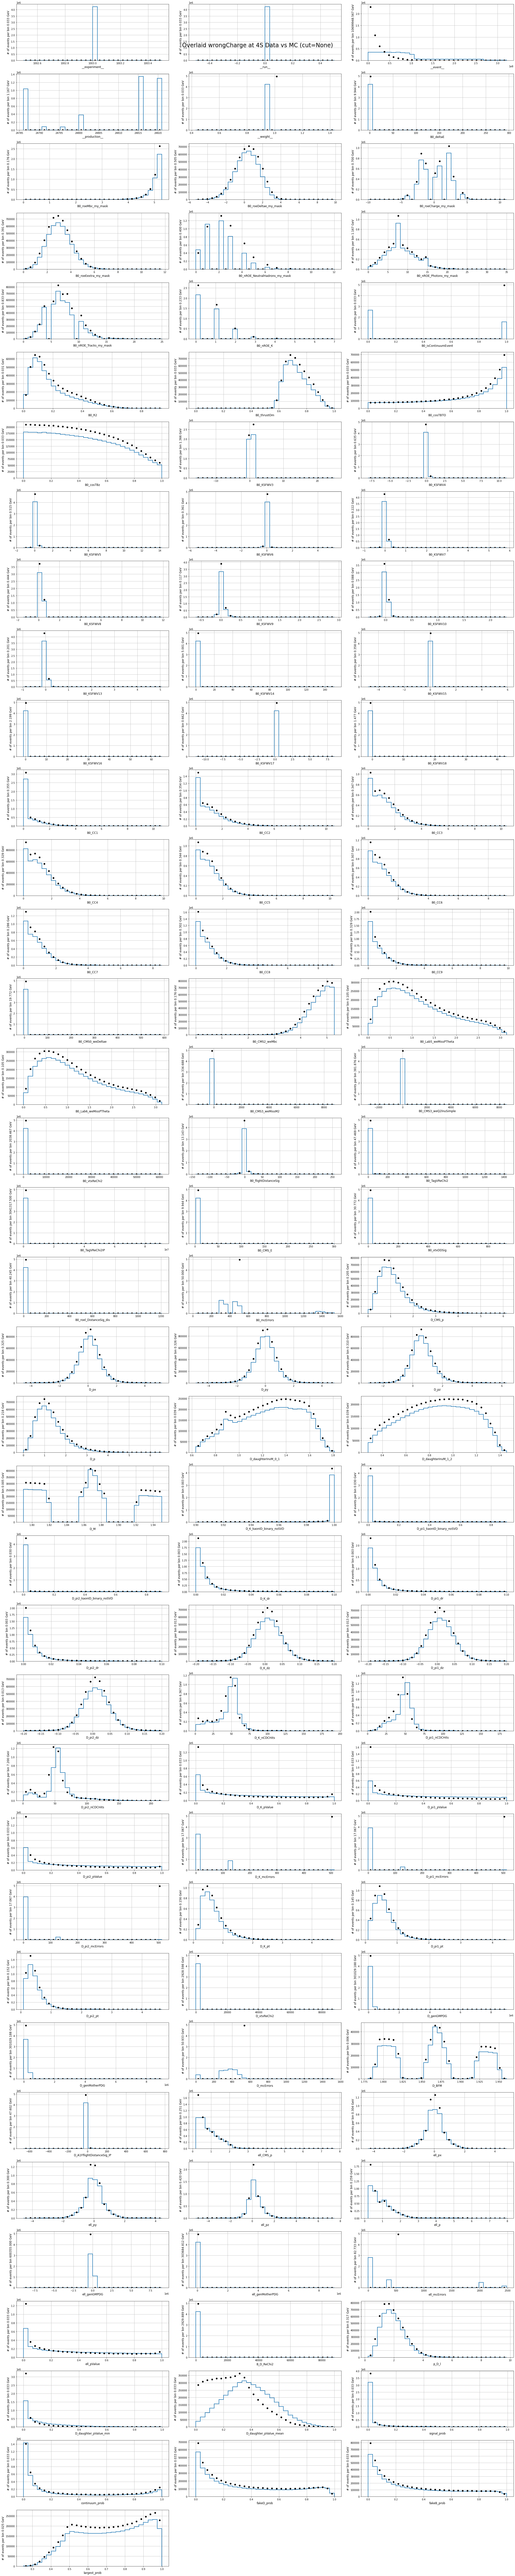

In [14]:
plot_data_mc(data=df_bestSelected_data, mc=df_bestSelected_mc, 
             bins=30,variables=columns_without_nan,cut=None,scale=[1.86/2,1],
            figsize=(30, 150), fontsize=12)

In [7]:
columns_without_nan = df_data_wc_BDT_sig.columns[~df_data_wc_BDT_sig.isna().any()].tolist()

samples_control=util.get_dataframe_samples_new(df_mc_wc_BDT_sig, 'e', template=False)
samples_sig = util.get_dataframe_samples_new(df_mc_cc_BDT_sig, 'e', template=False)
mpl=util.mpl(samples_control,df_data_wc_BDT_sig)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples_control.items():
    print(name, len(df))

bkg_FakeD 15371
bkg_TDFl 326
bkg_fakeTracks 349
bkg_continuum 69
bkg_combinatorial 2480
bkg_singleBbkg 66
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$ 0
$D\ell\nu$_gap 0
bkg_other_signal 0


# Check WC vs. CC

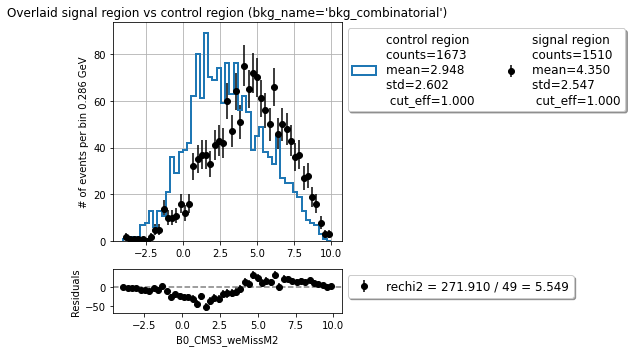

In [7]:
# compare control vs signal regions MC
b1 = np.linspace(-4,10,50)
scale = {'control region': 1,
         'signal region': 1}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_combinatorial',
                        cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

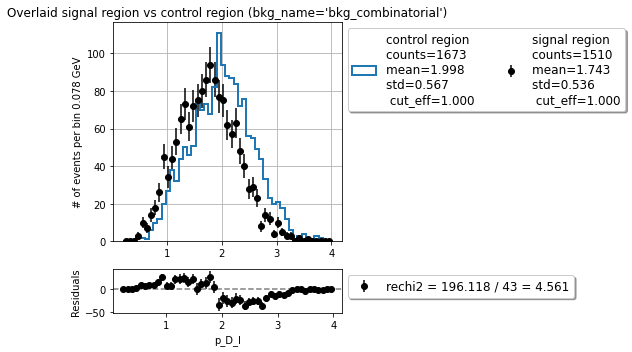

In [8]:
b2 = np.linspace(0.2,4,50)
scale = {'control region': 1,
         'signal region': 1}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,
                        bkg_name='bkg_combinatorial',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

In [10]:
print('Wrong charge sample')
samples_control['bkg_combinatorial'][['ell_genMotherPDG','D_genMotherPDG']].value_counts().head(15)

Wrong charge sample


ell_genMotherPDG  D_genMotherPDG
 511.0            -511.0            336
-511.0             511.0            314
 511.0             413.0            161
-511.0            -413.0            128
-521.0             521.0             63
 521.0            -521.0             59
-15.0             -511.0             47
 411.0            -511.0             35
 521.0             413.0             35
-411.0             511.0             33
 15.0              511.0             27
 431.0            -511.0             27
-521.0            -413.0             26
 421.0            -511.0             26
 411.0             413.0             23
Name: count, dtype: int64

In [11]:
print('Correct charge sample')
samples_sig['bkg_combinatorial'][['ell_genMotherPDG','D_genMotherPDG']].value_counts().head(15)

Correct charge sample


ell_genMotherPDG  D_genMotherPDG
-411.0            -511.0            195
 411.0             511.0            191
                  -413.0            105
-411.0             413.0             98
-421.0            -511.0             77
 421.0            -413.0             63
                   511.0             55
 521.0            -521.0             48
-511.0            -511.0             47
-521.0             521.0             45
-511.0             511.0             41
 511.0             511.0             37
-421.0             413.0             36
-511.0             413.0             31
 521.0            -413.0             25
Name: count, dtype: int64

In [16]:
print(len(samples_control['bkg_combinatorial']), len(samples_sig['bkg_combinatorial']))

1673 1512


In [14]:
# 2 primary
samples_control['bkg_combinatorial'].query('511<=abs(ell_genMotherPDG)<=521 and 511<=abs(D_genMotherPDG)<=521')[
    ['ell_genMotherPDG','D_genMotherPDG']].value_counts().sum()

776

In [17]:
# 2 secondary
samples_control['bkg_combinatorial'].query('abs(ell_genMotherPDG)<511 and abs(D_genMotherPDG)<511')[
    ['ell_genMotherPDG','D_genMotherPDG']].value_counts().sum()

141

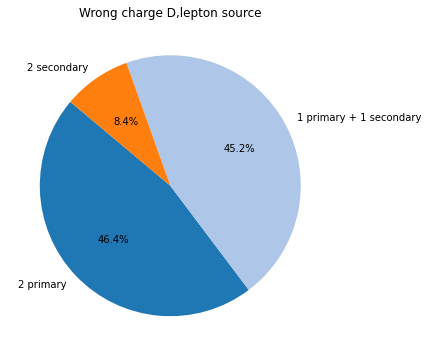

In [19]:
# Example data
sizes = [776, 1673-776-141, 141]  # Portion sizes for each component
labels = ['2 primary', '1 primary + 1 secondary', '2 secondary']  # Names of each component

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Optional: adjust the size of the figure
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Wrong charge D,lepton source')
plt.show()

### Conclusion: Cannot use data driven for combinatorial bkg, WC and CC have different physics
#### Consider using MC template CC

# Check Data vs. MC

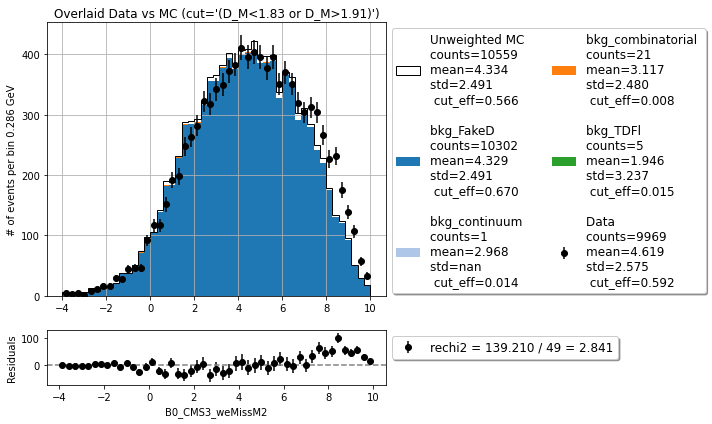

In [53]:
# sidebands
b1 = np.linspace(-4,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=True,mask=[],ratio=False)

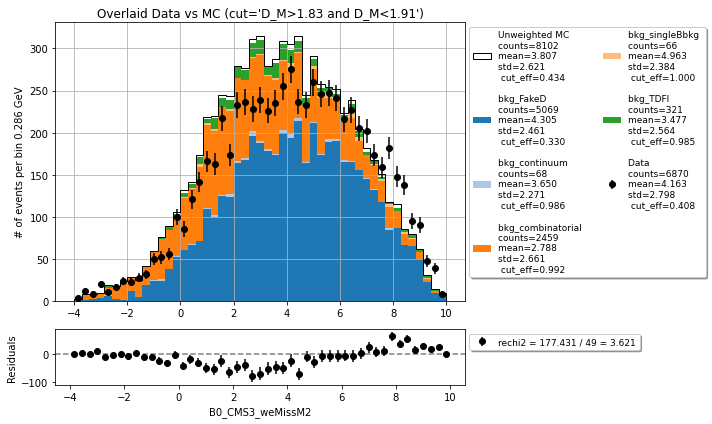

In [59]:
# signal
b1 = np.linspace(-4,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,ratio=False,
                          cut='D_M>1.83 and D_M<1.91',scale=[1,187/200],
                             correction=True,mask=[],figsize=(10,6),
                            legend_fs=9)

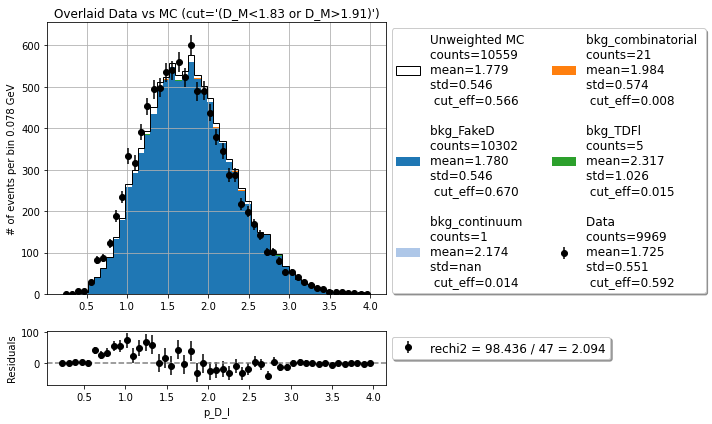

In [60]:
# sidebands
b2 = np.linspace(0.2,4,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=True,mask=[],figsize=(10,6))

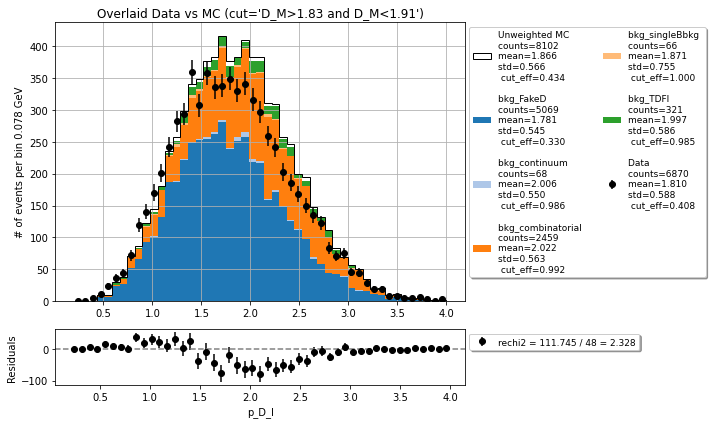

In [61]:
# signal
b2 = np.linspace(0.2,4,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='D_M>1.83 and D_M<1.91',scale=[1,187/200],
                             correction=True,mask=[],figsize=(10,6),
                            legend_fs=9)

# Create data driven template for FakeD
## 1. Calculate the sidebands to sig region scaling factors
### a. Histogram the D_M distribution

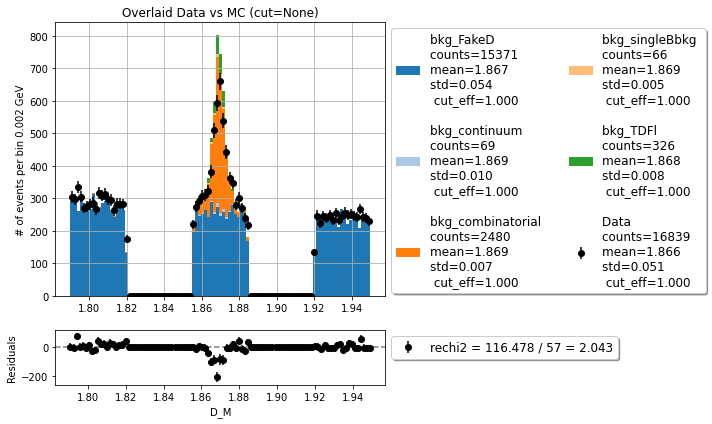

In [8]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut=None,scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False)

### b. fit the FakeD with a polynomial

In [9]:
fitter = util.fit_iminuit(x_edges=b1, hist=mc_hist_all, poly_only=False)

In [8]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls

initial parameters= [ 3.400e+00  1.870e+00  5.000e-02 -2.472e+02  6.355e+02]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 64.77 (chi2/ndof = 1.3)    │              Nfcn = 371              │
│ EDM = 1.19e-10 (Goal: 0.0002)    │           time = 28.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   3.96    │   0.12    │            │            │    0    │         │       │
│ 1 │ x1   │  1.86998  │  0.00010  │            │            │    0    │         │       │
│ 2 │ x2   │  3.19e-3  │  0.12e-3  │            │            │    0    │         │       │
│ 3 │ x3   │   -310    │    40     │            │            │         │         │       │
│ 4 │ x4   │    850    │    70     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │    0.0154 -2.74e-08  6.78e-06     0.161     -0.41 │
│ x1 │ -2.74e-08   1.1e-08  1.37e-11 -0.000108  0.000203 │
│ x2 │  6.78e-06  1.37e-11  1.35e-08  0.000115 -0.000294 │
│ x3 │     0.161 -0.000108  0.000115  1.54e+03  -2.9e+03 │
│ x4 │     -0.41  0.000203 -0.000294  -2.9e+03  5.44e+03 │
└────┴───────────────────────────────────────────────────┘

In [10]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml

initial parameters= [ 1.71220e+03  1.87000e+00  5.00000e-02  1.71217e+04 -2.47200e+02
  6.35100e+02]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 59.85 (chi2/ndof = 1.3)    │              Nfcn = 379              │
│ EDM = 9.86e-07 (Goal: 0.0002)    │           time = 23.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  2.45e3   │  0.08e3   │            │            │    0    │         │       │
│ 1 │ x1   │  1.86917  │  0.00011  │            │            │    0    │         │       │
│ 2 │ x2   │  3.15e-3  │  0.12e-3  │            │            │    0    │         │       │
│ 3 │ x3   │  26.16e3  │  0.25e3   │            │            │         │         │       │
│ 4 │ x4   │   -100    │    60     │            │            │         │         │       │
│ 5 │ x5   │  0.27e3   │  0.15e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │  6.48e+03  1.53e-05   0.00476 -7.52e+03      1.01      2.45 │
│ x1 │  1.53e-05  1.22e-08  6.64e-11    -3e-05 -6.36e-06 -1.54e-05 │
│ x2 │   0.00476  6.64e-11  1.44e-08  -0.00888  1.12e-06  2.67e-06 │
│ x3 │ -7.52e+03    -3e-05  -0.00888  6.29e+04     -1.88      -4.6 │
│ x4 │      1.01 -6.36e-06  1.12e-06     -1.88  3.11e+03  -8.4e+03 │
│ x5 │      2.45 -1.54e-05  2.67e-06      -4.6  -8.4e+03  2.28e+04 │
└────┴─────────────────────────────────────────────────────────────┘

### c. Calculate the yield ratio

In [ ]:
area_left,error_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ls)
area_sig, error_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ls)
area_right,error_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ls)

In [11]:
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82: 5287.422
Yields from 1.855 to 1.885: 4905.737
Yields from 1.92 to 1.95: 4524.051


In [12]:
a = len(samples_control['bkg_FakeD'].query('1.79<D_M<1.82')) * 187/200
b = len(samples_control['bkg_FakeD'].query('1.92<D_M<1.95')) * 187/200
print('truth',a,b, a/b)

truth 5170.55 4461.82 1.1588432523051133


### d. Plot and compare MC of the weighted sideband and signal region

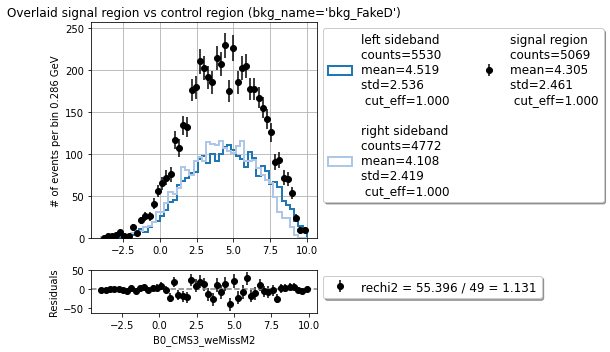

In [22]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=False,
                        scale=scale,correction=False,mask=[])

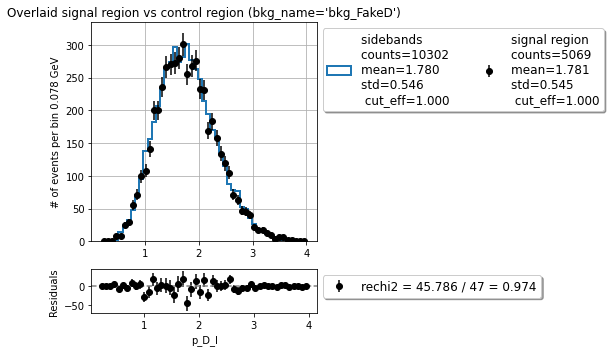

In [18]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut=None,
                        scale=scale,correction=False,mask=[])

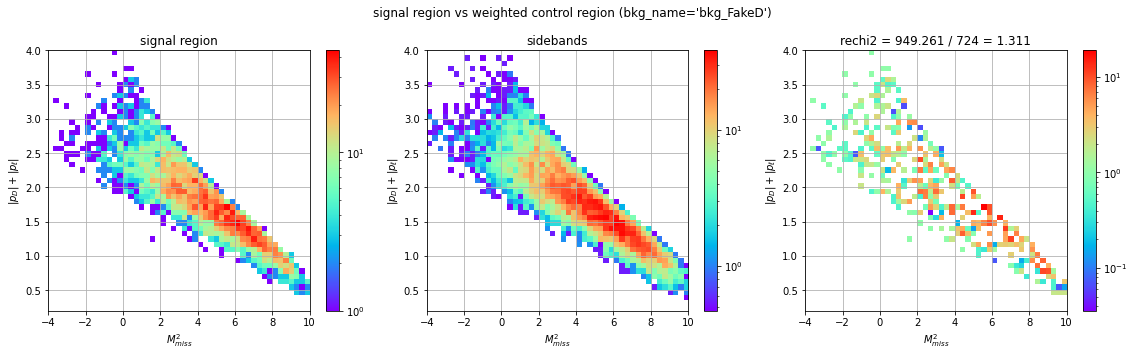

In [21]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[],figsize=(16,5))

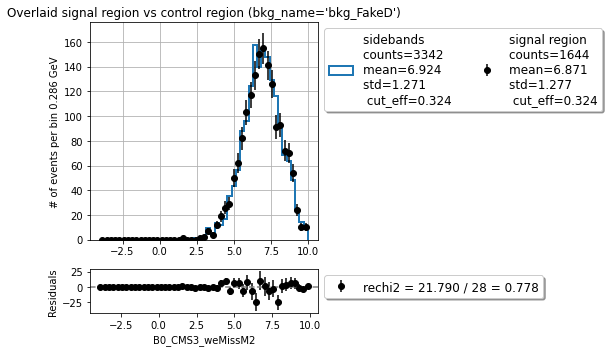

In [35]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut='p_D_l<1.5',merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

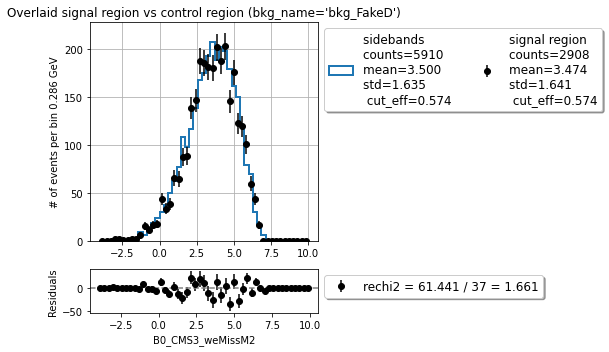

In [36]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut='1.5<p_D_l<2.5',merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

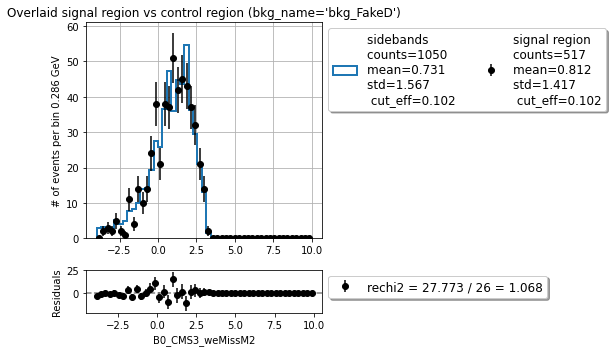

In [37]:
# calculating the scaling factors from mc
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut='2.5<p_D_l',merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

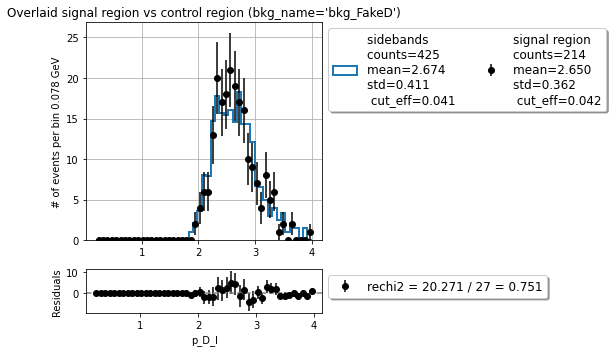

In [32]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut='B0_CMS3_weMissM2<0',
                        scale=scale,correction=False,mask=[])

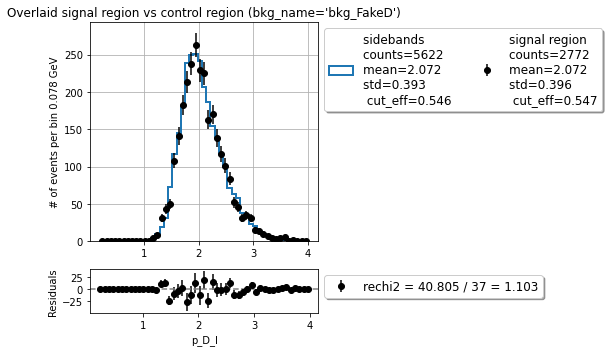

In [33]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut='0<B0_CMS3_weMissM2<5',
                        scale=scale,correction=False,mask=[])

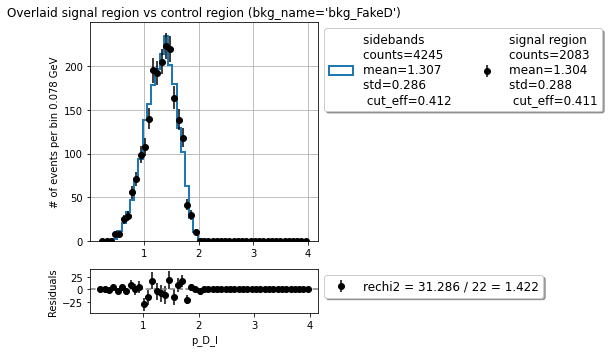

In [34]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut='5<B0_CMS3_weMissM2<10',
                        scale=scale,correction=False,mask=[])

## 2. Subtract the FakeD from the signal region

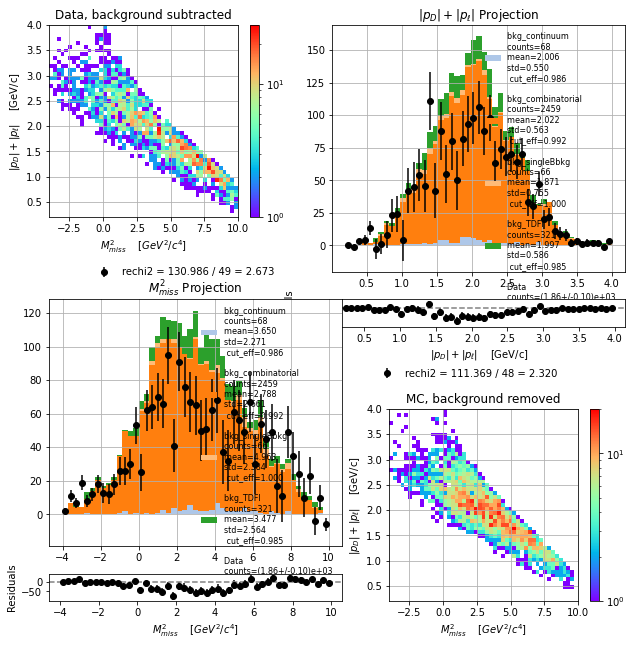

In [25]:
# subtract the scaled sidebands in the signal region
b_mm2 = np.linspace(-4,10,50)
b_pDl = np.linspace(0.2,4,50)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 187/200}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': False,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

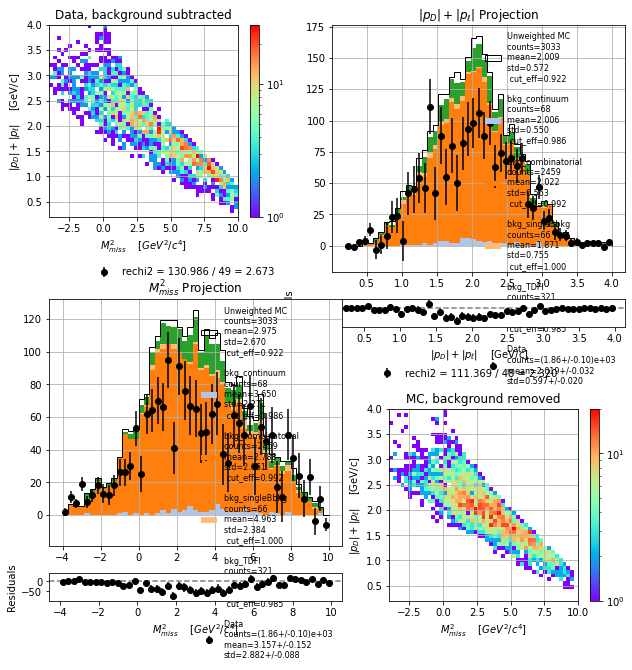

In [13]:
# subtract the scaled sidebands in the signal region
b_mm2 = np.linspace(-4,10,50)
b_pDl = np.linspace(0.2,4,50)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 187/200}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': True,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

## Lepton Correction

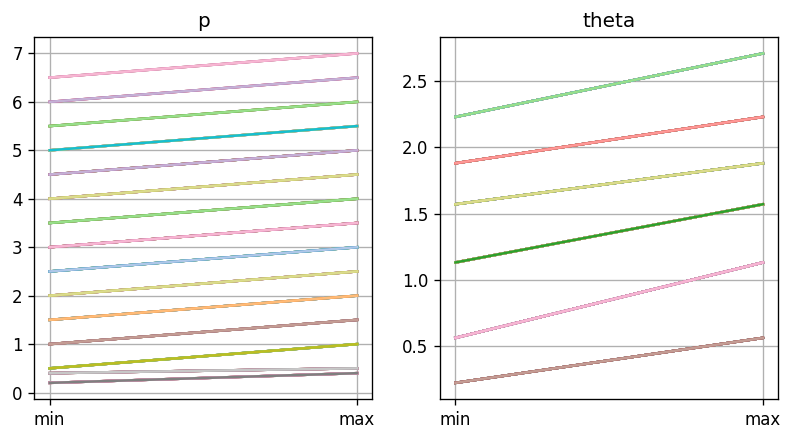

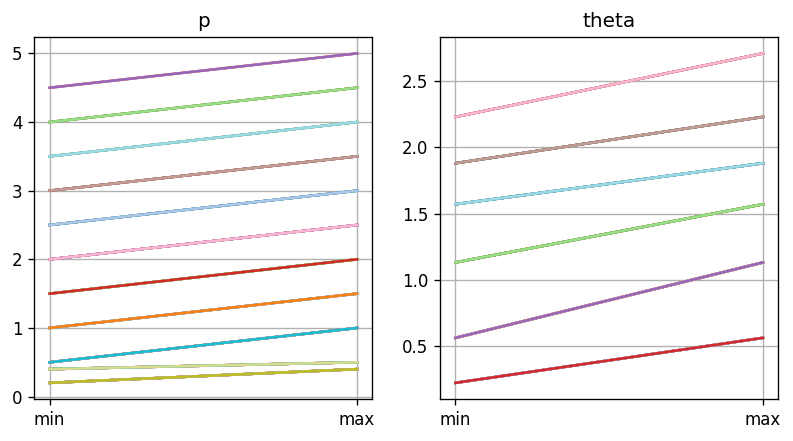

In [13]:
efficiency_e_table = pd.read_csv('~/B2SW/2024_OleMiss/systematics_framework/correction-tables/MC15/run_independent/PID/coarse_theta_binning/efficiency/e_efficiency_table.csv')
pi_e_fake_table = pd.read_csv('~/B2SW/2024_OleMiss/systematics_framework/correction-tables/MC15/run_independent/PID/coarse_theta_binning/fakeRate/pi_e_fakeRate_table.csv')

final_query = 'is_best_available == True'
final_query += ' and variable == "pidChargedBDTScore_e"'
final_query += ' and threshold == 0.9'
efficiency_e_table = efficiency_e_table.query(final_query)
pi_e_fake_table = pi_e_fake_table.query(final_query)

exclude_e_bins_query = "not (p_min == 0.2 and p_max == 5.0) "
exclude_e_bins_query += "and not (theta_min == 0.22 and theta_max == 2.71) "
exclude_e_bins_query += "and not (theta_min == 0.56 and theta_max == 2.23)"

efficiency_e_table = efficiency_e_table.query(exclude_e_bins_query)
pi_e_fake_table = pi_e_fake_table.query(exclude_e_bins_query)

fig, axs = plt.subplots(1,2, figsize=(8, 4), dpi=120)
axs[0].plot(efficiency_e_table[['p_min', 'p_max']].values.T);
axs[1].plot(efficiency_e_table[['theta_min', 'theta_max']].values.T);
axs[0].set_xticks([0,1], ['min', 'max'])
axs[1].set_xticks([0,1], ['min', 'max'])
axs[0].set_title('p')
axs[1].set_title('theta')
axs[0].grid()
axs[1].grid();

fig, axs = plt.subplots(1,2, figsize=(8, 4), dpi=120)
axs[0].plot(pi_e_fake_table[['p_min', 'p_max']].values.T);
axs[1].plot(pi_e_fake_table[['theta_min', 'theta_max']].values.T);
axs[0].set_xticks([0,1], ['min', 'max'])
axs[1].set_xticks([0,1], ['min', 'max'])
axs[0].set_title('p')
axs[1].set_title('theta')
axs[0].grid()
axs[1].grid();

## Hadron Correction

In [14]:
efficiency_K_table = pd.read_csv('tables/k_efficiency.csv', index_col=None)
pi_K_fake_table = pd.read_csv('tables/pi_K_fake.csv', index_col=None)

## Apply corrections

In [15]:
import warnings
from sysvar import add_weights_to_dataframe

e_tables = {(11, 11): efficiency_e_table,
            (11, 211): pi_e_fake_table
}
e_thresholds = {11: ('pidChargedBDTScore_e', 0.9)}

df_bestSelected_mc = df_bestSelected_mc.reset_index() # for a bug in add_weights_to_dataframe

Welcome to JupyROOT 6.26/14


Required variables: ['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 90.0%


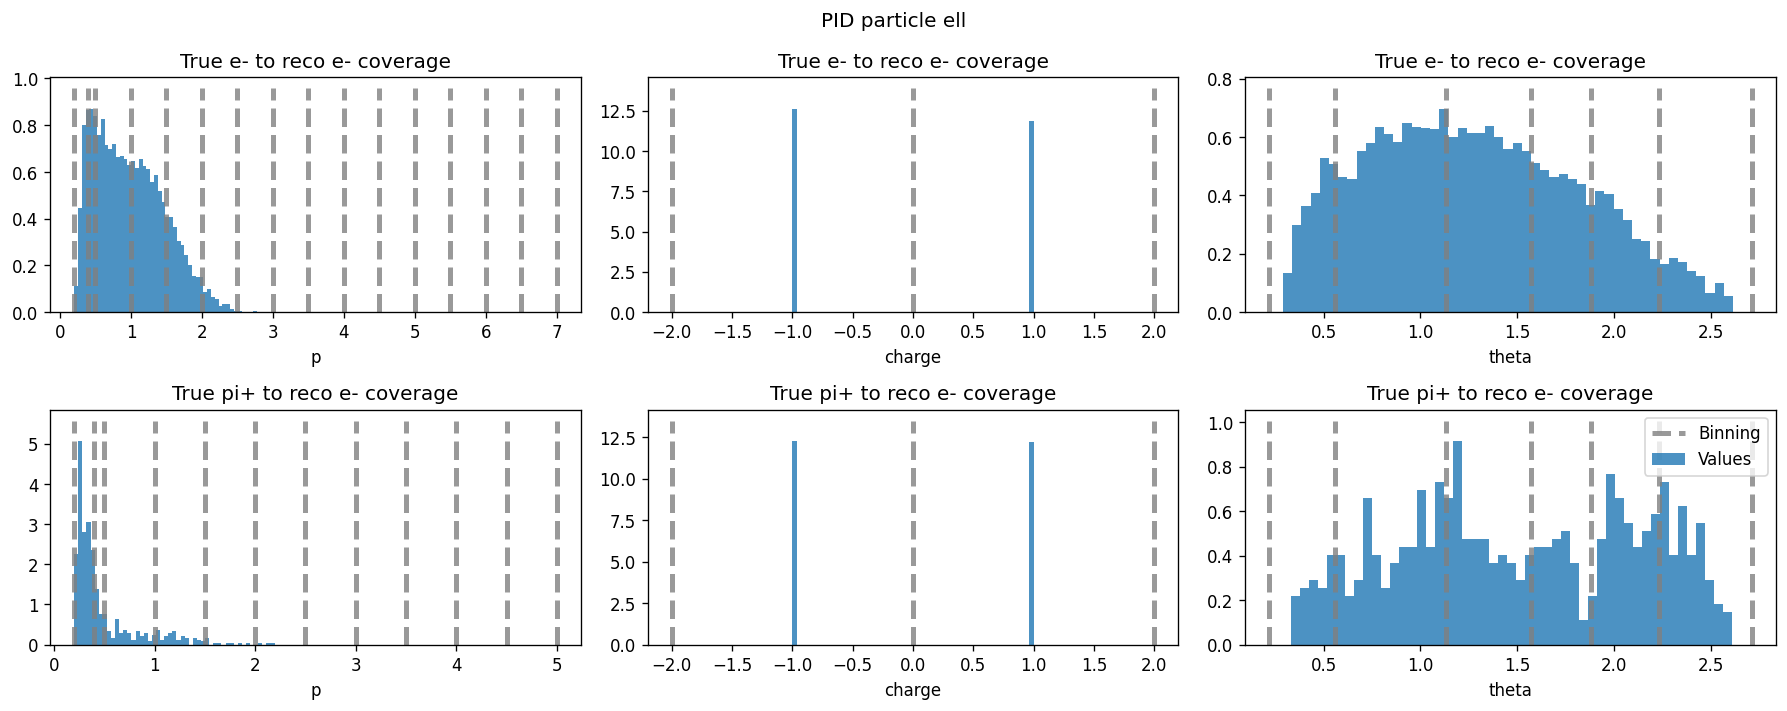

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    add_weights_to_dataframe('ell',
                             df_bestSelected_mc,
                             systematic='custom_PID',
                             custom_tables=e_tables,
                             custom_thresholds=e_thresholds,
                             show_plots=True,
                             sys_seed=0)

Required variables: ['D_K_cosTheta', 'D_K_p', 'D_K_charge', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 90.5%


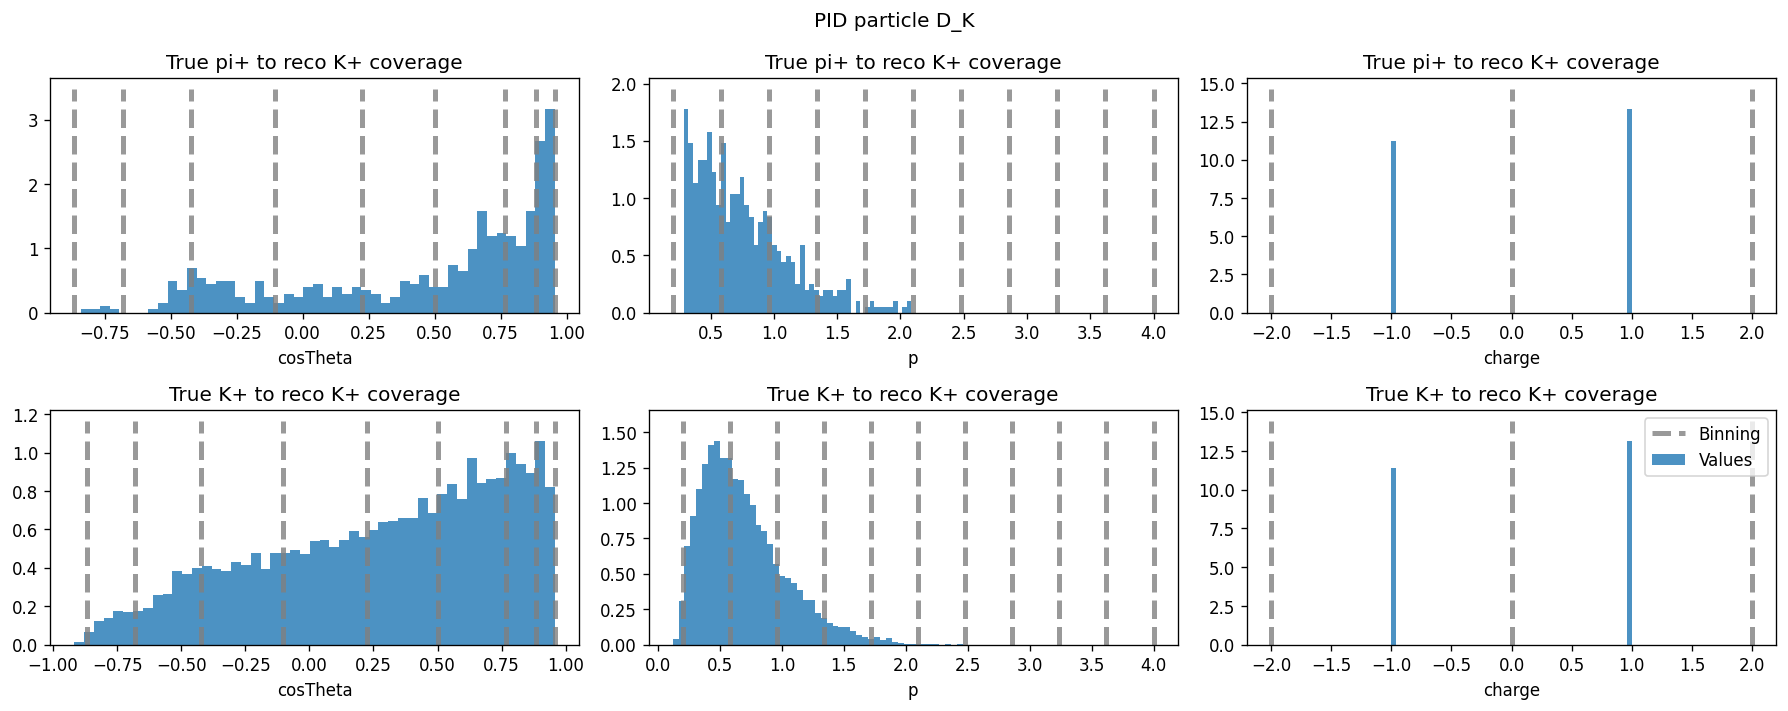

In [17]:
k_tables = {(321, 321): efficiency_K_table,
            (321, 211): pi_K_fake_table}
k_thresholds = {321: ('kaonID', 0.9)}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    add_weights_to_dataframe('D_K',
                             df_bestSelected_mc,
                             systematic='custom_PID',
                             custom_tables=k_tables,
                             custom_thresholds=k_thresholds,
                             show_plots=True)

In [18]:
df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc[['ell_Weight', 'D_K_Weight']].product(axis=1)

/tmp/ipykernel_83976/85433479.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc[['ell_Weight', 'D_K_Weight']].product(axis=1)


In [19]:
samples=util.get_dataframe_samples_new(df_bestSelected_mc, 'e', template=False)
mpl=util.mpl(samples,df_bestSelected_data)

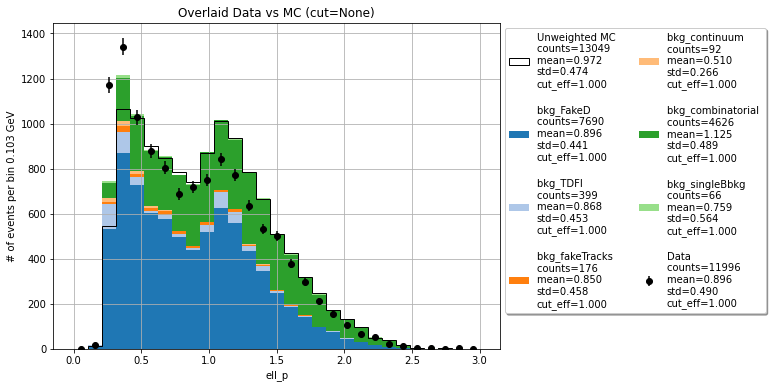

In [22]:
b1 = np.linspace(0,3,30)
mpl.plot_data_mc_overlaid(variable='ell_p',bins=b1,cut=None,scale=[1, 1.87/2],correction=True)

In [18]:
# Assuming your DataFrame is named 'df'
# Use dtypes attribute to get the data types of each column
column_data_types = samples[r'$D\tau\nu$'].dtypes

# Filter the columns that have data type 'object' (strings)
columns_with_strings = column_data_types[column_data_types == 'object'].index.tolist()

# Now, columns_with_strings contains the names of columns with strings
print("Columns with strings:", columns_with_strings)


Columns with strings: []


In [8]:
# Check for duplicate entries
util.check_duplicate_entries(samples)

No duplicate pairs found.
